### Author: Anh Nguyen
### DSC630-T303 Predictive Analytics
### Course Project
### 03/02/2025

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, FeatureHasher
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import sys

# Load dataset
df = pd.read_csv("C:/Users/anhng/Documents/Masters/630/Project/reviews.csv")
df2 = pd.read_csv("C:/Users/anhng/Documents/Masters/630/Project/offerings.csv")

# Create copies
reviews = df.copy()
offerings = df2.copy()

# Data Cleaning

# Create a function to clean text
def clean_text(text):
    """Remove non-ASCII characters and unwanted symbols from text."""
    if isinstance(text, str):
        text = text.encode("ascii", "ignore").decode()  # Remove non-ASCII while preserving structure
        text = text.strip()
    return text

# Clean the 'reviews' dataframe
reviews['title'] = reviews['title'].apply(clean_text)
reviews['text'] = reviews['text'].apply(clean_text)

# Create a function to parse columns
def parse_json_column(column_value):
    if isinstance(column_value, str):
        try:
            return json.loads(column_value.replace("'", "\""))
        except json.JSONDecodeError:
            return {}
    return {}

# Parse and normalize 'author' and 'ratings' columns in 'reviews' dataframe
reviews['author'] = reviews['author'].apply(parse_json_column)
reviews['ratings'] = reviews['ratings'].apply(parse_json_column)

author_df = pd.json_normalize(reviews['author'])
ratings_df = pd.json_normalize(reviews['ratings']).rename(columns={'location': 'hotel_location'})
reviews = pd.concat([reviews, author_df, ratings_df], axis=1).drop(['author', 'ratings'], axis=1)

# Convert date column to datetime format for future analysis
if 'date' in reviews.columns:
    reviews['date'] = pd.to_datetime(reviews['date'], errors='coerce')
    reviews['year'] = reviews['date'].dt.year  
    reviews['month'] = reviews['date'].dt.month 

# Drop unnecessary columns
reviews.drop(['via_mobile'], axis=1, inplace=True)

# Handle missing values
for column in reviews.columns:
    if pd.api.types.is_numeric_dtype(reviews[column]):
        reviews[column] = reviews[column].fillna(0)
    else:
        reviews[column] = reviews[column].fillna('').astype(str)

# Rename columns in 'offerings' dataframe
offerings.rename(columns={'name': 'hotel_name', 'id': 'offering_id'}, inplace=True)

# Parse and normalize 'address' column in 'offerings' dataframe
offerings['address'] = offerings['address'].apply(parse_json_column)

offerings_df = pd.json_normalize(offerings['address'])
offerings = pd.concat([offerings, offerings_df], axis=1).drop(['address'], axis=1)

# Merge the 'reviews' dataframe with the 'offerings' dataframe to get hotel name
merged_df = reviews.merge(offerings, left_on='offering_id', right_on='offering_id', how='left')

# Check dataset structure
print(merged_df.info())
print(merged_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878561 entries, 0 to 878560
Data columns (total 36 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   title                                   878561 non-null  object 
 1   text                                    878561 non-null  object 
 2   date_stayed                             878561 non-null  object 
 3   offering_id                             878561 non-null  int64  
 4   num_helpful_votes                       878561 non-null  object 
 5   date                                    878561 non-null  object 
 6   id                                      878561 non-null  object 
 7   username                                878561 non-null  object 
 8   num_cities                              878561 non-null  float64
 9   num_helpful_votes                       878561 non-null  object 
 10  num_reviews                             8785

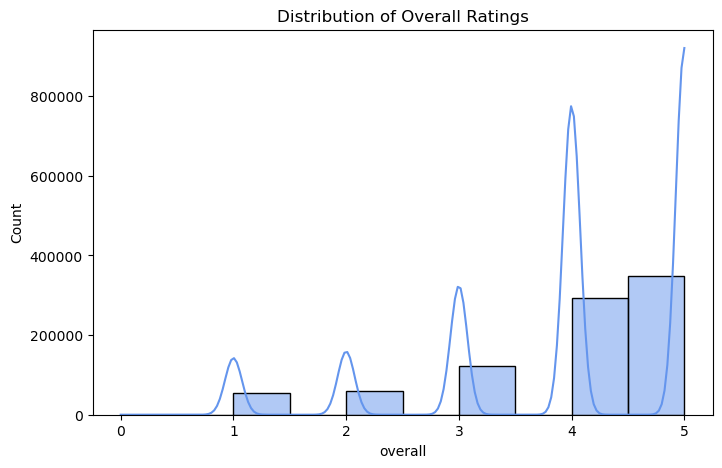

In [3]:
# Exploratory Data Analysis

# Distribution of overall ratings
plt.figure(figsize=(8,5))
sns.histplot(merged_df['overall'], bins=10, kde=True, color="cornflowerblue")
plt.title("Distribution of Overall Ratings")
plt.show()

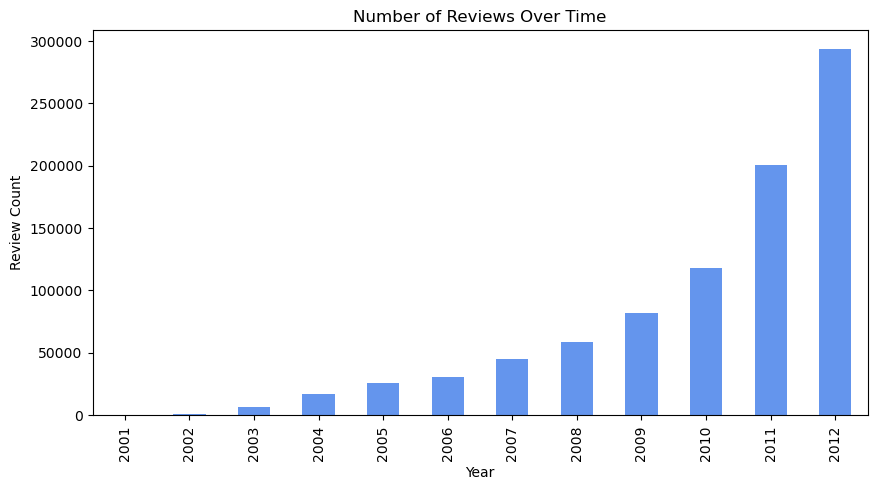

In [4]:
# Distribution of reviews over time
plt.figure(figsize=(10,5))
merged_df.groupby('year').size().plot(kind='bar', color='cornflowerblue')
plt.title("Number of Reviews Over Time")
plt.xlabel("Year")
plt.ylabel("Review Count")
plt.show()

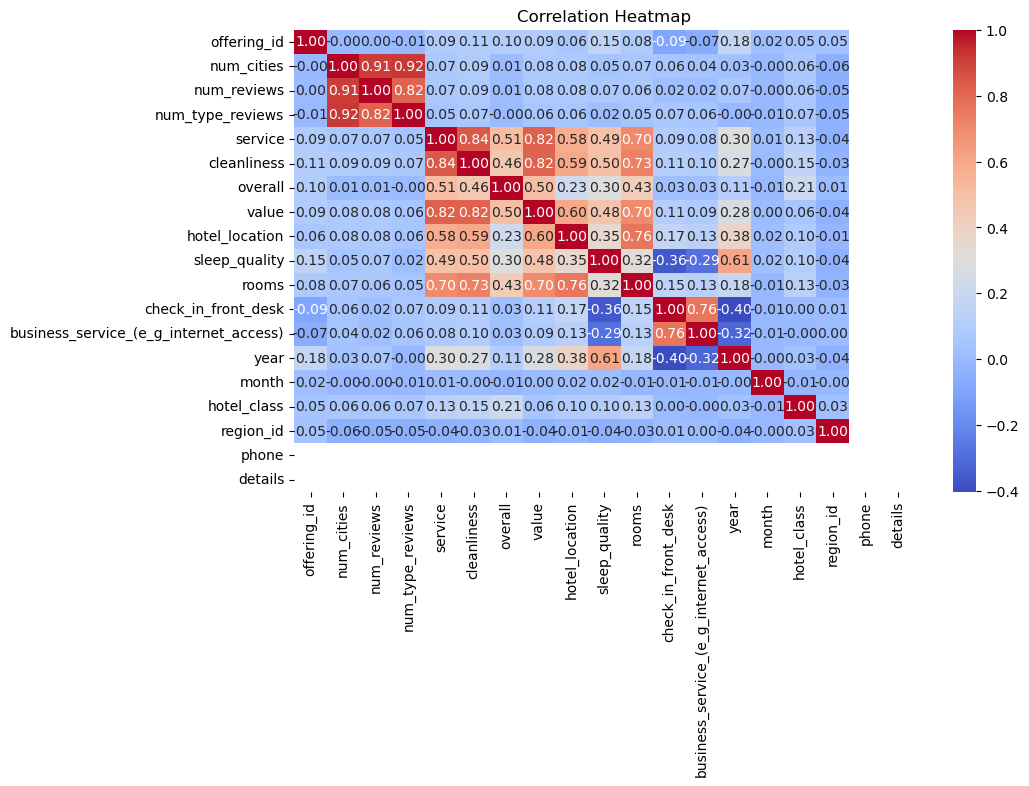

In [5]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(merged_df.select_dtypes(include=['number']).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [6]:
# Feature Engineering

# Combine title and text for NLP processing
merged_df['combined_text'] = merged_df['title'].astype(str) + ' ' + merged_df['text'].astype(str)

# TF-IDF transformation
vectorizer = TfidfVectorizer(stop_words='english', max_features=300)
X_text = vectorizer.fit_transform(merged_df['combined_text'])

# Reduce dimensionality
svd = TruncatedSVD(n_components=50, random_state=42)
X_text_reduced = svd.fit_transform(X_text)

# Convert and extract date components
merged_df['date_stayed'] = pd.to_datetime(merged_df['date_stayed'], format='%B %Y', errors='coerce')
merged_df['date_stayed_month'] = merged_df['date_stayed'].dt.month.astype(np.float32)
merged_df['date_stayed_year'] = merged_df['date_stayed'].dt.year.astype(np.float32)

# Hash categorical features
hasher = FeatureHasher(n_features=100, input_type='string')
property_id_hashed = hasher.transform(merged_df['offering_id'].astype(str).apply(lambda x: [x]).tolist()).toarray()
location_hashed = hasher.transform(merged_df['location'].astype(str).apply(lambda x: [x.split(',')[0]]).tolist()).toarray()

# Combine all features
ratings = merged_df[['service', 'cleanliness', 'overall', 'value', 'hotel_location', 'sleep_quality', 'rooms']].astype(np.float32)
X_additional = np.hstack([property_id_hashed, location_hashed, merged_df[['date_stayed_month', 'date_stayed_year']].to_numpy(), ratings.to_numpy()])

# Scale features
scaler = StandardScaler()
X_additional_scaled = scaler.fit_transform(X_additional)

# Final feature matrix
X = np.hstack([X_text_reduced, X_additional_scaled])
X = SimpleImputer(strategy="mean").fit_transform(X)

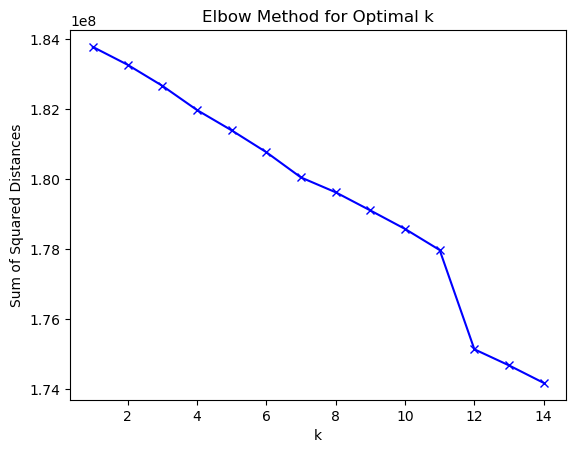

In [7]:
# Clustering Model

# Find optimal k using Elbow Method
sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    sum_of_squared_distances.append(km.inertia_)

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')
plt.show()

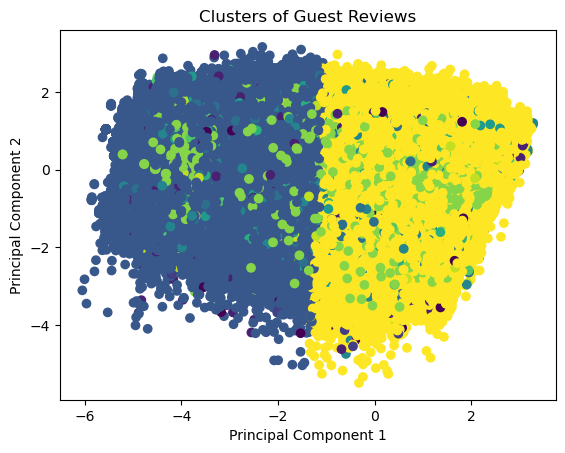

In [8]:
# Apply K-Means clustering
optimal_clusters = 12
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(X)
merged_df['cluster'] = kmeans.labels_

# PCA for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=merged_df['cluster'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters of Guest Reviews')
plt.show()

In [9]:
# Top terms per cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(optimal_clusters):
    print(f"Cluster {i}:")
    print(', '.join([terms[ind] for ind in order_centroids[i, :10]]))
    print("\n")

Cluster 0:
es, property, 00, thing, thought, suite, sure, super, high, things


Cluster 1:
look, 00, think, suite, super, thing, things, quality, double, thought


Cluster 2:
inn, 00, high, little, location, left, having, far, free, le


Cluster 3:
little, 00, concierge, quality, expensive, having, 10, pretty, kids, didn


Cluster 4:
00, think, things, thing, pool, suite, super, shower, people, paid


Cluster 5:
00, super, suite, thing, thought, things, quality, pool, nights, didn


Cluster 6:
00, think, things, super, thing, quality, suite, pool, subway, thought


Cluster 7:
00, thing, things, suite, super, think, quality, pool, thought, shower


Cluster 8:
really, 00, suite, thing, super, think, thought, things, sure, subway


Cluster 9:
places, 00, things, quality, super, short, didn, think, suite, nights


Cluster 10:
00, things, nights, super, high, location, think, pool, having, service


Cluster 11:
thing, super, suite, thought, things, 00, sure, think, quality, subway




In [10]:
# Function to get top 10 recommended hotels
def recommend_hotels(user_name, city, min_hotel_class, max_hotel_class):
    """Recommend up to 10 hotels for a user based on their cluster, past stays, and minimum hotel class."""

    # Get the cluster the user belongs to
    user_cluster = merged_df.loc[merged_df['username'] == user_name, 'cluster'].values[0]

    # Get other users in the same cluster
    users_in_cluster = merged_df[merged_df['cluster'] == user_cluster]['username'].unique()

    # Get hotels that users in the same cluster have rated
    hotels_liked_by_cluster = merged_df[merged_df['username'].isin(users_in_cluster)]

    # Convert hotel_class to numeric, handling errors and remove NaNs
    hotels_liked_by_cluster = hotels_liked_by_cluster.copy()

    # Filter by city and hotel class
    hotels_liked_by_cluster = hotels_liked_by_cluster[
        (hotels_liked_by_cluster['locality'] == city) & 
        (hotels_liked_by_cluster['hotel_class'] >= min_hotel_class) &
        (hotels_liked_by_cluster['hotel_class'] <= max_hotel_class)
    ]

    # Convert hotel_class to numeric, handling errors and remove NaNs
    hotels_liked_by_cluster['hotel_class'] = pd.to_numeric(hotels_liked_by_cluster['hotel_class'], errors='coerce')
    hotels_liked_by_cluster = hotels_liked_by_cluster.dropna(subset=['hotel_class'])

    # Get hotels the user has already visited
    visited_hotels = set(merged_df.loc[merged_df['username'] == user_name, 'hotel_name'])

    # Remove hotels the user has already visited
    recommended_hotels = hotels_liked_by_cluster[~hotels_liked_by_cluster['hotel_name'].isin(visited_hotels)]

    # Rank hotels by average overall rating
    top_hotels = (recommended_hotels.groupby('hotel_name')
                                   .agg({'overall': 'mean'})
                                   .reset_index()
                                   .sort_values(by='overall', ascending=False)
                                   .head(10))

    top_hotels = top_hotels.merge(offerings, on=['hotel_name'], how='inner')
    top_hotels = top_hotels[top_hotels['locality'] == city]

    if top_hotels.empty:
        print("No hotels match the criteria.")
        return None
    
    # Create the Address column
    top_hotels['Address'] = top_hotels.apply(
        lambda row: f"{row['street-address']}, {row['locality']}, {row['region']} {row['postal-code']}", axis=1
    )

    # Select and rename columns
    top_hotels = top_hotels[['hotel_class', 'overall', 'hotel_name', 'Address']]
    top_hotels.columns = ['Hotel Class', 'Guest Rating', 'Hotel Name', 'Address']

    # Round Overall Star Rating to one decimal place
    top_hotels['Guest Rating'] = top_hotels['Guest Rating'].round(1)

    # Reset index to print numbers 1-10
    top_hotels = top_hotels.reset_index(drop=True)
    top_hotels.index += 1
    
    return top_hotels

In [ ]:
# Interactive loop for user input
while True:
    user_name = input("Enter your username: (ex. WYbirdwatcher, WillyWonka2, or Simopel)").strip()
    if user_name in merged_df['username'].values:
        break
    else:
        print("Invalid username. Please enter a valid username.")

def display_top_hotels(top_hotels):
    if top_hotels is not None and not top_hotels.empty:
        print("\n⭐ Based on past hotels you've liked, our top recommended hotels for you are: ⭐\n")
    
        for idx, (_, row) in enumerate(top_hotels.iterrows(), start=1):
            # Round guest rating to the nearest integer
            rounded_rating = round(row['Guest Rating'])
            stars = "⭐" * rounded_rating
            
            print(f"{idx}. {row['Hotel Name']} - 🏨 Hotel Class: {row['Hotel Class']} - Guest Rating: {stars} - 📍 {row['Address']}")
    else:
        print("\nNo hotel recommendations found based on your criteria.")

while True:
    # Provide city options without duplicates and remove NaN values
    available_cities = merged_df['locality']

    # Remove NaN values and convert to a set to remove duplicates
    available_cities = set(city for city in available_cities if pd.notna(city))

    # Convert all elements to strings and sort them
    available_cities = sorted(str(city) for city in available_cities)

    print("\nAvailable cities to choose from:")
    for idx, city in enumerate(available_cities, start=1):
        print(f"{idx}. {city}")
    
    while True:
        try:
            city_choice = int(input("\nEnter the number of the city you plan to visit: ").strip())
            if 1 <= city_choice <= len(available_cities):
                city = available_cities[city_choice - 1] 
                break
            else:
                print("\nInvalid choice. Please enter a number from the list.")
        except ValueError:
            print("\nInvalid input. Please enter a valid number.")

    while True:
        try:
            min_hotel_class = float(input("\nEnter your desired minimum hotel class (1 to 5): "))
            max_hotel_class = float(input("\nEnter your desired maximum hotel class (1 to 5): "))
            if 1 <= min_hotel_class <= 5 and 1 <= max_hotel_class <= 5 and min_hotel_class <= max_hotel_class:
                break
            else:
                print("\nInvalid ratings. Please enter numbers between 1 and 5, ensuring the maximum hotel class is not less than the minimum hotel class.")
        except ValueError:
            print("\nInvalid input. Please enter numbers between 1 and 5.")
    
    top_hotels = recommend_hotels(user_name, city, min_hotel_class, max_hotel_class)
    display_top_hotels(top_hotels)

    # Ask if the user wants to update the hotel class for the same city, search for another city, or exit the program
    while True:
        print("\nWould you like to:")
        print("1. Update your desired minimum and maximum hotel class")
        print("2. Search for another city")
        print("3. Exit")

        choice = input("\nPlease enter the number of your choice: ")
        
        if choice == '1':
            while True:
                try:
                    min_hotel_class = float(input("\nEnter your new desired minimum hotel class (1 to 5): "))
                    max_hotel_class = float(input("\nEnter your new desired maximum hotel class (1 to 5): "))
                    if 1 <= min_hotel_class <= 5 and 1 <= max_hotel_class <= 5 and min_hotel_class <= max_hotel_class:
                        break
                    else:
                        print("\nInvalid ratings. Please enter numbers between 1 and 5, ensuring the maximum hotel class is not less than the minimum hotel class.")
                except ValueError:
                    print("\nInvalid input. Please enter a number between 1 and 5.")
            top_hotels = recommend_hotels(user_name, city, min_hotel_class, max_hotel_class)
            display_top_hotels(top_hotels)
        elif choice == '2':
            break
        elif choice == '3':
            try:
                sys.exit()
            except SystemExit:
                print("Exiting program...")
                break
        else:
            print("\nInvalid choice. Please try again.")

Enter your username: (ex. WYbirdwatcher, WillyWonka2, or Simopel) WillyWonka2



Available cities to choose from:
1. Austin
2. Baltimore
3. Boston
4. Charlotte
5. Chicago
6. Columbus
7. Dallas
8. Denver
9. Detroit
10. El Paso
11. Fort Worth
12. Houston
13. Indianapolis
14. Jacksonville
15. Los Angeles
16. Memphis
17. New York City
18. Philadelphia
19. Phoenix
20. San Antonio
21. San Diego
22. San Francisco
23. San Jose
24. Seattle
25. Washington DC



Enter the number of the city you plan to visit:  4

Enter your desired minimum hotel class (1 to 5):  2

Enter your desired maximum hotel class (1 to 5):  3



⭐ Based on past hotels you've liked, our top recommended hotels for you are: ⭐

1. Continental Inn - 🏨 Hotel Class: 2.0 - Guest Rating: ⭐⭐⭐⭐⭐ - 📍 1100 West Sugar Creek Road, Charlotte, NC 28213
2. Drury Inn & Suites Charlotte Northlake - 🏨 Hotel Class: 3.0 - Guest Rating: ⭐⭐⭐⭐⭐ - 📍 6920 Northlake Mall Dr, Charlotte, NC 28216
3. Residence Inn Charlotte Uptown - 🏨 Hotel Class: 3.0 - Guest Rating: ⭐⭐⭐⭐⭐ - 📍 404 S Mint St, Charlotte, NC 28202
4. Hampton Inn Charlotte - South Park - 🏨 Hotel Class: 2.5 - Guest Rating: ⭐⭐⭐⭐⭐ - 📍 6700 Phillips Place Court, Charlotte, NC 28210
5. Hampton Inn and Suites Charlotte Airport - 🏨 Hotel Class: 2.5 - Guest Rating: ⭐⭐⭐⭐⭐ - 📍 2731 Little Rock Road, Charlotte, NC 28214
6. HYATT house Charlotte Center City - 🏨 Hotel Class: 3.0 - Guest Rating: ⭐⭐⭐⭐ - 📍 435 E Trade St, Charlotte, NC 28202
7. Homewood Suites Charlotte/Ayrsley - 🏨 Hotel Class: 3.0 - Guest Rating: ⭐⭐⭐⭐ - 📍 1921 Ayrsley Town Blvd, Charlotte, NC 28273
8. Aloft Charlotte Ballantyne - 🏨 Hotel Clas


Please enter the number of your choice:  2



Available cities to choose from:
1. Austin
2. Baltimore
3. Boston
4. Charlotte
5. Chicago
6. Columbus
7. Dallas
8. Denver
9. Detroit
10. El Paso
11. Fort Worth
12. Houston
13. Indianapolis
14. Jacksonville
15. Los Angeles
16. Memphis
17. New York City
18. Philadelphia
19. Phoenix
20. San Antonio
21. San Diego
22. San Francisco
23. San Jose
24. Seattle
25. Washington DC



Enter the number of the city you plan to visit:  22

Enter your desired minimum hotel class (1 to 5):  4

Enter your desired maximum hotel class (1 to 5):  5



⭐ Based on past hotels you've liked, our top recommended hotels for you are: ⭐

1. Fairmont Heritage Place, Ghirardelli Square - 🏨 Hotel Class: 5.0 - Guest Rating: ⭐⭐⭐⭐⭐ - 📍 900 North Point Street, San Francisco, CA 94109
2. Hotel Drisco - 🏨 Hotel Class: 4.0 - Guest Rating: ⭐⭐⭐⭐⭐ - 📍 2901 Pacific Avenue, San Francisco, CA 94115
3. Omni San Francisco Hotel - 🏨 Hotel Class: 4.5 - Guest Rating: ⭐⭐⭐⭐⭐ - 📍 500 California Street, San Francisco, CA 94104
4. Four Seasons Hotel San Francisco - 🏨 Hotel Class: 5.0 - Guest Rating: ⭐⭐⭐⭐⭐ - 📍 757 Market Street, San Francisco, CA 94103
5. Mandarin Oriental, San Francisco - 🏨 Hotel Class: 5.0 - Guest Rating: ⭐⭐⭐⭐ - 📍 222 Sansome Street, San Francisco, CA 94104
6. Hotel Monaco San Francisco - a Kimpton Hotel - 🏨 Hotel Class: 4.0 - Guest Rating: ⭐⭐⭐⭐ - 📍 501 Geary St, San Francisco, CA 94102
7. St. Regis Hotel, San Francisco - 🏨 Hotel Class: 5.0 - Guest Rating: ⭐⭐⭐⭐ - 📍 125 3rd St, San Francisco, CA 94103
8. The Ritz-Carlton - 🏨 Hotel Class: 5.0 - Gues